In [1]:
!pip install plotly kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.4 MB/s eta 0:00:00


In [2]:
!pip install -U kaleido

In [3]:
!pip install pycountry_convert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 14.8 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import sklearn.metrics
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import pycountry_convert as pc
import plotly.io as pio
# from sklearn.metrics import root_mean_squared_error

In [48]:
url = 'https://raw.githubusercontent.com/Man-ella/Analyzing-Forecast-Global-CO2-Emissions/main/CO2_Emissions_1960-2018.csv'
df = pd.read_csv(url)

In [49]:
min_years_data = 45
df_cleaned = df.dropna(thresh=min_years_data, axis=0)
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_cleaned.iloc[:, 1:]), columns=df_cleaned.columns[1:], index=df_cleaned.index)
df_imputed.insert(0, df_cleaned.columns[0], df_cleaned.iloc[:, 0])
years = df_imputed.columns[1:]
X = df_imputed[years[:-5]]
y = df_imputed[years[-5:]]

In [50]:
df_imputed = df_imputed.rename(columns={'Country Name':'Countries'})
print(df_imputed.shape)
df_imputed

(205, 60)


,Countries,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
1,Africa Eastern and Southern,0.906060,0.922474,0.930816,0.940570,0.996033,1.047280,1.033908,1.052204,1.079727,...,1.021954,1.048876,1.005338,1.021646,1.031833,1.041145,0.987393,0.971016,0.959978,0.933541
2,Afghanistan,0.046057,0.053589,0.073721,0.074161,0.086174,0.101285,0.107399,0.123409,0.115142,...,0.211306,0.297065,0.407074,0.335351,0.263716,0.234037,0.232176,0.208857,0.203328,0.200151
3,Africa Western and Central,0.090880,0.095283,0.096612,0.112376,0.133258,0.184803,0.193676,0.189305,0.143989,...,0.426770,0.472819,0.497023,0.490867,0.504655,0.507671,0.480743,0.472959,0.476438,0.515544
4,Angola,0.100835,0.082204,0.210533,0.202739,0.213562,0.205891,0.268937,0.172096,0.289702,...,1.205902,1.221515,1.216317,1.204799,1.261542,1.285365,1.260921,1.227703,1.034317,0.887380
5,Albania,1.258195,1.374186,1.439956,1.181681,1.111742,1.166099,1.333055,1.363746,1.519551,...,1.475652,1.572251,1.734823,1.579092,1.654524,1.806789,1.759987,1.714126,1.948872,1.939732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,Samoa,0.135031,0.163542,0.158377,0.184037,0.208106,0.230892,0.196438,0.191301,0.213378,...,1.029515,1.021813,1.066843,1.057703,1.048702,1.092498,1.240246,1.542099,1.535642,1.631588
262,"Yemen, Rep.",0.011038,0.013599,0.012729,0.014518,0.017550,0.017926,0.017023,0.017380,0.021384,...,1.139166,1.036068,0.869051,0.804146,1.047834,1.034330,0.536269,0.400468,0.361418,0.326682
263,South Africa,5.727223,5.832621,5.887168,5.961337,6.332343,6.616545,6.453858,6.560824,6.593620,...,8.004039,8.300179,7.867124,8.076633,8.137333,8.213158,7.671202,7.564451,7.632729,7.496645
264,Zambia,0.260444,0.270796,0.357863,0.383009,0.946606,1.096875,0.951122,1.261960,1.166853,...,0.186907,0.194032,0.218210,0.277909,0.284058,0.311693,0.319282,0.341615,0.414748,0.446065


In [51]:

# getting rid of groupings
df_imputed = df_imputed[~df_imputed['Countries'].str.contains(r'\(|\)|:|IDA|IBRD', regex=True)] #replace bahamas, congo dem, egypt, korea

#getting rid of further groupings in countries
unwanted = ['Caribbean small states','Early-demographic dividend','Fragile and conflict affected situations','Latin America & Caribbean','World',
            'Low & middle income','Lower middle income','Late-demographic dividend','OECD members', 'Other small states','Upper middle income',
            'Pre-demographic dividend','Middle East & North Africa','Africa Eastern and Southern','Africa Western and Central','Arab World',
            'Middle income','Post-demographic dividend','Small states','Pacific island small states','Central Europe and the Baltics',
            'European Union','East Asia & Pacific','Europe & Central Asia','North America']

df_imputed = df_imputed[~df_imputed["Countries"].isin(unwanted)]

#renaming some countries to shorten them
df_imputed.loc[:,'Countries'] = df_imputed['Countries'].str.replace('Brunei Darussalam','Brunei')
df_imputed.loc[:,'Countries'] = df_imputed['Countries'].str.replace('Congo, Dem. Rep.','DR Congo')
df_imputed.loc[:,'Countries'] = df_imputed['Countries'].str.replace('Egypt, Arab Rep.','Egypt')
df_imputed.loc[:,'Countries'] = df_imputed['Countries'].str.replace("Korea, Dem. People's Rep.",'North Korea')
df_imputed.loc[:,'Countries'] = df_imputed['Countries'].str.replace('Syrian Arab Republic','Syria')
df_imputed.loc[:,'Countries'] = df_imputed['Countries'].str.replace('Bahamas, The','Bahamas')
df_imputed.loc[:,'Countries'] = df_imputed['Countries'].str.replace('Gambia, The','Gambia')
df_imputed.loc[:,'Countries'] = df_imputed['Countries'].str.replace('Iran, Islamic Rep.','Iran')
df_imputed.loc[:,'Countries'] = df_imputed['Countries'].str.replace('Lao PDR','Laos')

print(df_imputed.shape)

(162, 60)


In [52]:
url_new = "https://raw.githubusercontent.com/Man-ella/Analyzing-Forecast-Global-CO2-Emissions/main/CO2_Emissions_2018-2020.csv"
df_new = pd.read_csv(url_new)
df_new = df_new.rename(columns={'Country Name':'Countries'}).drop(columns='2018')
df_new.head()

,Countries,2019,2020
0,Africa Eastern and Southern,0.915294,0.795420
1,Afghanistan,0.297564,0.223479
2,Africa Western and Central,0.490837,0.463150
3,Angola,0.753638,0.592743
4,Albania,1.749462,1.544550


In [53]:
# getting rid of groupings
df_new = df_new[~df_new['Countries'].str.contains(r'\(|\)|:|IDA|IBRD', regex=True)] #replace bahamas, congo dem, egypt, korea

#getting rid of further groupings in countries
unwanted = ['Caribbean small states','Early-demographic dividend','Fragile and conflict affected situations','Latin America & Caribbean','World',
            'Low & middle income','Lower middle income','Late-demographic dividend','OECD members', 'Other small states','Upper middle income',
            'Pre-demographic dividend','Middle East & North Africa','Africa Eastern and Southern','Africa Western and Central','Arab World',
            'Middle income','Post-demographic dividend','Small states','Pacific island small states','Central Europe and the Baltics',
            'European Union','East Asia & Pacific','Europe & Central Asia','North America']

df_new = df_new[~df_new["Countries"].isin(unwanted)]

#renaming some countries to shorten them
df_new.loc[:,'Countries'] = df_new['Countries'].str.replace('Brunei Darussalam','Brunei')
df_new.loc[:,'Countries'] = df_new['Countries'].str.replace('Congo, Dem. Rep.','DR Congo')
df_new.loc[:,'Countries'] = df_new['Countries'].str.replace('Egypt, Arab Rep.','Egypt')
df_new.loc[:,'Countries'] = df_new['Countries'].str.replace("Korea, Dem. People's Rep.",'North Korea')
df_new.loc[:,'Countries'] = df_new['Countries'].str.replace('Syrian Arab Republic','Syria')
df_new.loc[:,'Countries'] = df_new['Countries'].str.replace('Bahamas, The','Bahamas')
df_new.loc[:,'Countries'] = df_new['Countries'].str.replace('Gambia, The','Gambia')
df_new.loc[:,'Countries'] = df_new['Countries'].str.replace('Iran, Islamic Rep.','Iran')
df_new.loc[:,'Countries'] = df_new['Countries'].str.replace('Lao PDR','Laos')


In [54]:
df_imputed.head()

,Countries,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
2,Afghanistan,0.046057,0.053589,0.073721,0.074161,0.086174,0.101285,0.107399,0.123409,0.115142,...,0.211306,0.297065,0.407074,0.335351,0.263716,0.234037,0.232176,0.208857,0.203328,0.200151
4,Angola,0.100835,0.082204,0.210533,0.202739,0.213562,0.205891,0.268937,0.172096,0.289702,...,1.205902,1.221515,1.216317,1.204799,1.261542,1.285365,1.260921,1.227703,1.034317,0.887380
5,Albania,1.258195,1.374186,1.439956,1.181681,1.111742,1.166099,1.333055,1.363746,1.519551,...,1.475652,1.572251,1.734823,1.579092,1.654524,1.806789,1.759987,1.714126,1.948872,1.939732
8,United Arab Emirates,0.119037,0.109136,0.163542,0.175833,0.132815,0.146822,0.160452,5.400016,6.807102,...,19.852557,19.043279,18.589933,19.223116,20.015421,19.951852,20.948092,21.307610,21.950614,20.797498
9,Argentina,2.383343,2.458551,2.538447,2.330685,2.553442,2.656466,2.806896,2.871099,2.981777,...,3.889060,4.122245,4.296015,4.277882,4.359886,4.216361,4.314434,4.227539,4.089472,3.987234


In [12]:
df_new.head()

,Countries,2019,2020
1,Afghanistan,0.297564,0.223479
3,Angola,0.753638,0.592743
4,Albania,1.749462,1.544550
5,Andorra,6.287204,5.777148
7,United Arab Emirates,20.153345,20.252272


In [13]:
df_imputed.to_csv('cleaned_CO2_data.csv')

In [14]:
df_imputed['Countries'].to_list()

['Afghanistan',
 'Angola',
 'Albania',
 'United Arab Emirates',
 'Argentina',
 'Antigua and Barbuda',
 'Australia',
 'Austria',
 'Burundi',
 'Belgium',
 'Benin',
 'Burkina Faso',
 'Bangladesh',
 'Bulgaria',
 'Bahrain',
 'Bahamas',
 'Belize',
 'Bolivia',
 'Brazil',
 'Barbados',
 'Brunei',
 'Bhutan',
 'Botswana',
 'Central African Republic',
 'Canada',
 'Switzerland',
 'Chile',
 'China',
 "Cote d'Ivoire",
 'Cameroon',
 'DR Congo',
 'Congo, Rep.',
 'Colombia',
 'Comoros',
 'Cabo Verde',
 'Costa Rica',
 'Cuba',
 'Cyprus',
 'Djibouti',
 'Dominica',
 'Denmark',
 'Dominican Republic',
 'Algeria',
 'Ecuador',
 'Egypt',
 'Spain',
 'Ethiopia',
 'Finland',
 'Fiji',
 'France',
 'Gabon',
 'United Kingdom',
 'Ghana',
 'Guinea',
 'Gambia',
 'Guinea-Bissau',
 'Equatorial Guinea',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guyana',
 'High income',
 'Honduras',
 'Haiti',
 'Hungary',
 'Indonesia',
 'India',
 'Ireland',
 'Iran',
 'Iraq',
 'Iceland',
 'Israel',
 'Italy',
 'Jamaica',
 'Jordan',
 'Japan',
 'Keny

In [ ]:
resultdf

,Countries,2018,2023 Predicted,5 Year Change (%)
2,Afghanistan,0.200151,0.210091,4.966439
4,Angola,0.887380,0.944795,6.470108
5,Albania,1.939732,1.982681,2.214212
8,United Arab Emirates,20.797498,37.255360,79.133850
9,Argentina,3.987234,4.027982,1.021948
...,...,...,...,...
260,Samoa,1.631588,1.718311,5.315264
262,"Yemen, Rep.",0.326682,0.351422,7.573068
263,South Africa,7.496645,7.543996,0.631628
264,Zambia,0.446065,0.457776,2.625379


In [ ]:
df_new.to_csv('cleaned_data_2019-2020.csv')

In [ ]:
# df_imputed.Countries.to_list()

**EDA**

In [ ]:
#can use this data frame if you want the total amount of co2 emissions per year
my_dates = []
sum_list = []
for each in df_imputed.columns[1:]: #1960,1961,...
  sum_of = 0
  my_dates.append(each)
  for country in df_imputed[each]:
    sum_of += country
  sum_list.append(sum_of)

new_df = pd.DataFrame({
    'dates': my_dates,
    'CO2 emissions (metric tons per capita)': sum_list
})

fig = px.line(new_df, x='dates', y='CO2 emissions (metric tons per capita)')
fig.update_layout(
    title = "The Worlds' CO2 Emissions from 1960 to 2018"
)

pio.write_image(fig, 'global_emissions.png')

fig.show()
#low at 1980 could be due to the global economic recessio that would have
#halted industrial activity/energy consumption
#increase from 1960 and 1970 (post world war II) could be due to manny reason
#such as - industrial expansion, economic growth, etc.

#need to do more reaserch and will make the graph look prettier later -
#maybe add some key dates that could have factored into the increase or decrease

Decade over decade change in CO2 emissions

In [ ]:
#reshaping the data
df_long = df_imputed.melt(id_vars=['Countries'], var_name='Year', value_name='CO2_emissions')

#assigning decades
df_long['Year'] = df_long['Year'].astype(int)
df_long['Decade'] = (df_long['Year']//10)*10

# calculating the mean the for each decade
decade_means = df_long.groupby(['Countries', 'Decade'])['CO2_emissions'].mean().reset_index()

#calculating pct change from decade to decade per country
decade_means['pct_change'] = np.round(decade_means.groupby('Countries')['CO2_emissions'].pct_change()*100, 2)

#dropning NaNs for every 1960 decade
decade_changes = decade_means.dropna(subset=['pct_change'])
display(decade_changes)

,Countries,Decade,CO2_emissions,pct_change
1,Afghanistan,1970,0.156638,80.57
2,Afghanistan,1980,0.219035,39.84
3,Afghanistan,1990,0.098762,-54.91
4,Afghanistan,2000,0.081999,-16.97
5,Afghanistan,2010,0.264639,222.74
...,...,...,...,...
967,Zimbabwe,1970,1.469664,46.38
968,Zimbabwe,1980,1.347523,-8.31
969,Zimbabwe,1990,1.431597,6.24
970,Zimbabwe,2000,0.873389,-38.99


In [ ]:
decade_changes['Decade'] = decade_changes['Decade'].astype(str)
fig = px.choropleth(
    decade_changes,
    locations="Countries",
    locationmode='country names',
    color="pct_change",
    hover_name="Countries",
    color_continuous_scale=px.colors.sequential.Reds,
    animation_frame = "Decade",
    title="Decade Over Decade Change in CO2 Emissions Per Capita"
)
#for the added animation frame
fig.update_layout(
    coloraxis_colorbar=dict(
        title="pct_change"
    )
)
# Save as HTML
fig.write_html("evolution of global CO2 emissions.html")
fig.show()

<ipython-input-78-2a6b7592cddf>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Top CO2 emitters in 2018

In [ ]:
_2018 = df_imputed[['Countries','2018']]
top10 = _2018.sort_values('2018', ascending=False, ignore_index=True).iloc[0:10]
bottom10 = _2018.sort_values('2018', ignore_index=True).iloc[0:10]
top10

,Countries,2018
0,Qatar,32.415639
1,Kuwait,21.622724
2,United Arab Emirates,20.797498
3,Bahrain,19.592976
4,Brunei,16.644909
5,Palau,16.191167
6,Canada,15.497025
7,Australia,15.475516
8,Luxembourg,15.330208
9,Saudi Arabia,15.268781


CO2 Emissions by the United States

In [ ]:
US = df_imputed[df_imputed['Countries']=='United States']
US = US.melt(id_vars=['Countries'], var_name='Year', value_name='CO2_emissions')
US.drop(columns='Countries', inplace=True)
print(US.dtypes)

Year              object
CO2_emissions    float64
dtype: object


In [ ]:
China = df_imputed[df_imputed['Countries']=='China']
China = China.melt(id_vars=['Countries'], var_name='Year', value_name='CO2_emissions')
China.drop(columns='Countries', inplace=True)
print(China.dtypes)

Year              object
CO2_emissions    float64
dtype: object


In [ ]:
fig = make_subplots(rows=1,cols=2, subplot_titles=('US','China'))

fig.add_trace(
    go.Line(x=US["Year"], y=US['CO2_emissions'], name='US'),
    row=1,col=1)

fig.add_trace(
    go.Line(x=China["Year"], y=China['CO2_emissions'], name='China'),
    row=1,col=2
    )
fig.update_layout(
    title = {'text':"Comparing US and China over 1960 to 2018", 'x':.5}
)

fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_yaxes(title_text="Metric Tons per Capita", row=1, col=1)

fig.update_xaxes(title_text="Year", row=1, col=2)
fig.update_yaxes(title_text="Metric Tons per Capita", row=1, col=2)

#fig.show()

/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




**Prediction Models**

ARIMA: does a poor job eventually

In [ ]:
A_data = df_long.copy()
A_data['Year'] = pd.to_datetime(A_data['Year'], format='%Y').dt.year
A_data.set_index('Year', inplace=True)
# A_data

In [ ]:
countries = df_imputed.Countries.to_list()
#countries


In [ ]:
US_df = A_data[A_data['Countries']=='United States']

In [ ]:
#checking stationarity
result = adfuller(US_df['CO2_emissions'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
#negative ADF ~ strong hint of stationarity
#p-value < 0.05 hits stationarity of time series

ADF Statistic: -1.868691715282283
p-value: 0.3469297660574229


In [ ]:
#differencing for statioanarity
US_df['CO2_emissions_diff'] = US_df['CO2_emissions'].diff().dropna()

<ipython-input-59-839bc8aa70f5>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



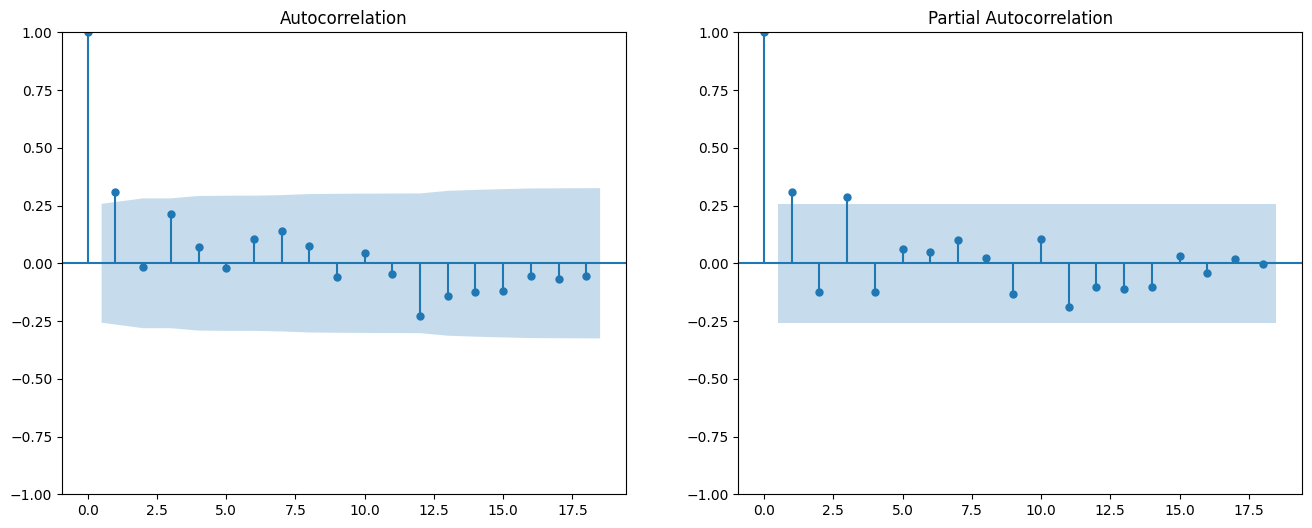

In [ ]:
# to choose hyper parameter p,q,d
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(US_df['CO2_emissions_diff'].dropna(), ax=axes[0])
plot_pacf(US_df['CO2_emissions_diff'].dropna(), ax=axes[1])
plt.show()

In [ ]:
#choosing hyperparameters
p,q,d = 1,1,1

In [ ]:
#splitting the data
train_size = int(len(US_df) * 0.8)
train, test = US_df[:train_size], US_df[train_size:]

In [ ]:
#model initiation and fitting
model = ARIMA(train['CO2_emissions'], order=(p, d, q))
model_fit = model.fit()
#test['CO2_emissions']

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



In [ ]:
#predictions
forecast = model_fit.forecast(steps=len(test))
# forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



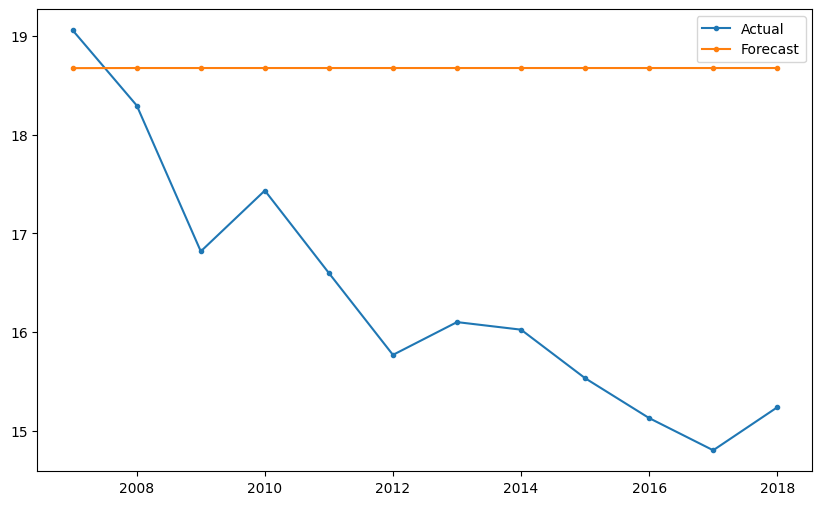

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['CO2_emissions'], label='Actual',marker='.')
plt.plot(test.index, forecast, label='Forecast', marker='.')
plt.legend()
plt.show()

Linear Regressor

In [ ]:
model = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(model, X, y, cv=tscv)
print("Cross-validation scores:", cv_scores)
print("Average cross-validation score:", np.mean(cv_scores))

Cross-validation scores: [-50.79349145 -20.83839866 -28.06017908          nan          nan]
Average cross-validation score: nan


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 117, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 723, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py", line 911, in r2_score
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py", line 101, in _check_reg_targets
    y_true = check_array(y_true, ensur

MLR

In [ ]:
from statsmodels.formula.api import ols

In [ ]:
OLS_data = df_long.drop(columns=['Decade'])
Actual_2018 = OLS_data[OLS_data['Year'] ==2018]
OLS_data = OLS_data[OLS_data['Year']<=2017]
OLS_data.head()

,Countries,Year,CO2_emissions
0,Afghanistan,1960,0.046057
1,Angola,1960,0.100835
2,Albania,1960,1.258195
3,United Arab Emirates,1960,0.119037
4,Argentina,1960,2.383343


In [ ]:
# len(countries)
all_predictions = []
for country in countries:
  country_df = OLS_data[OLS_data['Countries']==country]

  X = country_df[['Year']]
  y = country_df['CO2_emissions']

  model = LinearRegression()
  model.fit(X,y)

  predict_2018 = model.predict(pd.DataFrame({'Year': [2018]}))
  predict_2019 = model.predict(pd.DataFrame({'Year': [2019]}))

  actual_2018 = Actual_2018[Actual_2018['Countries']==country]['CO2_emissions'].values

  RSME = np.sqrt(mean_squared_error(actual_2018, predict_2018))
  all_predictions.append({
      "country": country,
      "2018_actual" : actual_2018[0],
      "2018_predict" : predict_2018[0],
      "RSME" : np.round(RSME, 2),
      "2019_predict" : predict_2019[0]
  })

MLR_predictions = pd.DataFrame(all_predictions)
MLR_predictions.head()
RSME

0.13184682106506385

In [ ]:
MLR_predictions['RSME'].mean()

0.8483333333333334

In [46]:
df_imputed

,Countries,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Continent
2,Afghanistan,0.046057,0.053589,0.073721,0.074161,0.086174,0.101285,0.107399,0.123409,0.115142,...,0.297065,0.407074,0.335351,0.263716,0.234037,0.232176,0.208857,0.203328,0.200151,Asia
4,Angola,0.100835,0.082204,0.210533,0.202739,0.213562,0.205891,0.268937,0.172096,0.289702,...,1.221515,1.216317,1.204799,1.261542,1.285365,1.260921,1.227703,1.034317,0.887380,Africa
5,Albania,1.258195,1.374186,1.439956,1.181681,1.111742,1.166099,1.333055,1.363746,1.519551,...,1.572251,1.734823,1.579092,1.654524,1.806789,1.759987,1.714126,1.948872,1.939732,Europe
8,United Arab Emirates,0.119037,0.109136,0.163542,0.175833,0.132815,0.146822,0.160452,5.400016,6.807102,...,19.043279,18.589933,19.223116,20.015421,19.951852,20.948092,21.307610,21.950614,20.797498,Asia
9,Argentina,2.383343,2.458551,2.538447,2.330685,2.553442,2.656466,2.806896,2.871099,2.981777,...,4.122245,4.296015,4.277882,4.359886,4.216361,4.314434,4.227539,4.089472,3.987234,South America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,Vanuatu,0.259155,0.270462,0.595002,0.471849,0.864427,0.641878,1.008051,1.074339,0.772928,...,0.550344,0.535733,0.480952,0.428621,0.606318,0.516361,0.646724,0.595449,0.615017,Oceania
260,Samoa,0.135031,0.163542,0.158377,0.184037,0.208106,0.230892,0.196438,0.191301,0.213378,...,1.021813,1.066843,1.057703,1.048702,1.092498,1.240246,1.542099,1.535642,1.631588,Oceania
263,South Africa,5.727223,5.832621,5.887168,5.961337,6.332343,6.616545,6.453858,6.560824,6.593620,...,8.300179,7.867124,8.076633,8.137333,8.213158,7.671202,7.564451,7.632729,7.496645,Africa
264,Zambia,0.260444,0.270796,0.357863,0.383009,0.946606,1.096875,0.951122,1.261960,1.166853,...,0.194032,0.218210,0.277909,0.284058,0.311693,0.319282,0.341615,0.414748,0.446065,Africa


Random Forest Regression

In [55]:
# Random Forest Regressor below

years = df_imputed.columns[1:]
X = df_imputed[years[:-5]].values
y = df_imputed[years[-5:]].values
model = RandomForestRegressor(n_estimators=100, random_state=42)
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error')
print("Cross-validation scores:", -cv_scores)
print("Average cross-validation score:", -np.mean(cv_scores))
model.fit(X, y)
y_pred = model.predict(X)
df_predictions = pd.DataFrame(y_pred, columns=[f"Pred_{year}" for year in range(2019, 2024)], index=df_imputed.iloc[:, 0])
df_predictions.insert(0, 'Country', df_imputed.iloc[:, 0])
df_ranked = df_predictions.iloc[:, 1:].mean(axis=1).sort_values(ascending=False).reset_index()
df_ranked.columns = ['Country', 'Average_Predicted_CO2_Emissions']
rmse_scores = np.sqrt(-cv_scores)
print("Cross-validation RMSE scores:", rmse_scores)
print("Average cross-validation RMSE:", np.mean(rmse_scores))

Cross-validation scores: [1.47016548 1.4981173  1.65495361 6.60964399 0.42313318]
Average cross-validation score: 2.331202712177128
Cross-validation RMSE scores: [1.21250381 1.22397602 1.28645    2.57092279 0.65048688]
Average cross-validation RMSE: 1.3888678995421277


In [152]:
# Predict next 10 years, save into a separate csv file
future_years = [f"Pred_{year}" for year in range(2019, 2029)]
future_predictions = []
X_future = X.copy()

for i in range(10):
    y_future = model.predict(X_future)
    y_future = y_future[:, -1].reshape(-1, 1)
    X_future = np.column_stack((X_future[:, 1:], y_future))
    future_predictions.append(y_future)

future_predictions = np.hstack(future_predictions)
df_future_predictions = pd.DataFrame(future_predictions, columns=future_years)

df_future_predictions.insert(0, 'Country', df_imputed.reset_index()['Countries'])

RF_output = df_future_predictions

output_file_path = 'CO2_Future_Predictions_RandomForest.csv'
df_future_predictions.to_csv(output_file_path, index=False)
print(f"Predictions saved to {output_file_path}")
RF_output

Predictions saved to CO2_Future_Predictions_RandomForest.csv


,Country,Pred_2019,Pred_2020,Pred_2021,Pred_2022,Pred_2023,Pred_2024,Pred_2025,Pred_2026,Pred_2027,Pred_2028
0,Afghanistan,0.247712,0.238811,0.292998,0.346153,0.343186,0.338134,0.354430,0.424046,0.556597,0.616921
1,Angola,1.149060,1.227839,1.284963,1.396514,1.541572,1.689383,1.795236,1.984233,2.186555,2.240016
2,Albania,1.834547,1.954978,2.079607,2.103990,2.146544,2.131326,2.164309,2.142476,2.227177,2.294780
3,United Arab Emirates,21.212246,22.069253,22.725691,21.999473,22.103853,21.178156,20.805923,20.507951,20.057745,19.891049
4,Argentina,4.183358,4.227428,4.170196,4.067442,4.043063,3.986105,3.955694,3.909602,3.889160,3.847526
...,...,...,...,...,...,...,...,...,...,...,...
157,Samoa,1.398752,1.506929,1.712264,1.897404,2.048396,2.189178,2.288917,2.395411,2.402343,2.442613
158,"Yemen, Rep.",0.781543,1.209791,1.122845,1.413057,1.611838,1.738735,1.978198,2.280522,2.495476,2.715208
159,South Africa,7.425722,7.383714,7.227231,6.839049,5.747799,5.656168,5.768359,5.712833,5.521888,5.409164
160,Zambia,0.387896,0.426940,0.491954,0.519299,0.564197,0.638919,0.841439,0.845690,1.046032,1.079353


**SKIP OVER UNTIL I SAY _ THIS IS FOR THE GRAPH**

to be able to run, you need get_continent and continent_date_pivot_old (both down further)

In [80]:

future_5 = 5
future_10 = 10
latest_year = '2018'

RF_output['Continent'] = RF_output['Country'].apply(get_continent)

RF_output_n = RF_output.set_index('Country').T

# Reset index to convert dates to a column
RF_output_n = RF_output_n.reset_index().rename(columns={'index': 'Date'})

# Melt the DataFrame to long format
df_long = RF_output_n.melt(id_vars=['Date'], var_name='Country', value_name='Emissions')
def get_continent(country):
  try:
    country_alpha2 = pc.country_name_to_country_alpha2(country)
    continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    continent_name = pc.convert_continent_code_to_continent_name(continent_code)
    return continent_name
  except KeyError:
    return 'Unknown'

df_long['Continent'] = df_long['Country'].apply(get_continent)

# Filter out rows where continent is 'Unknown'
df_long = df_long[df_long['Continent'] != 'Unknown']

# Group by Date and Continent, and sum the emissions
continent_date_emissions = df_long.groupby(['Date', 'Continent'])['Emissions'].sum().reset_index()

# Pivot the table so that each row is a date and each column is a continent
continent_date_pivot = continent_date_emissions.pivot(index='Continent', columns='Date', values='Emissions')
continent_date_pivot.drop('Continent', axis = 1, inplace=True)
continent_date_pivot

Date,Pred_2019,Pred_2020,Pred_2021,Pred_2022,Pred_2023,Pred_2024,Pred_2025,Pred_2026,Pred_2027,Pred_2028
Continent,,,,,,,,,,
Africa,61.713575,63.220523,63.465286,64.334486,65.651612,66.489502,70.048443,72.21229,75.834995,78.332503
Asia,232.177752,227.307866,227.44945,226.738224,228.107816,228.901502,228.397205,228.500039,228.779848,228.695895
Europe,157.02949,154.077177,153.09046,153.464252,153.243287,152.062357,151.058273,150.148525,149.235127,147.528498
North America,95.229945,100.771132,101.183083,99.910542,100.447424,100.99208,100.608597,101.479804,102.393513,103.862001
Oceania,49.518565,48.273808,48.824769,49.01701,49.430446,49.670917,50.324084,50.613115,50.801269,51.311363
South America,28.765322,29.349362,29.615293,29.773161,30.183454,30.505081,30.72231,31.190059,31.828252,32.19577


In [83]:
new_list = []
for each in continent_date_pivot_old['2018']:
  new_list.append(each)
continent_date_pivot['2018'] = new_list
continent_date_pivot
#df_future_predictions_n = df_future_predictions

Date,Pred_2019,Pred_2020,Pred_2021,Pred_2022,Pred_2023,Pred_2024,Pred_2025,Pred_2026,Pred_2027,Pred_2028,2018
Continent,,,,,,,,,,,
Africa,61.713575,63.220523,63.465286,64.334486,65.651612,66.489502,70.048443,72.21229,75.834995,78.332503,61.061010
Asia,232.177752,227.307866,227.44945,226.738224,228.107816,228.901502,228.397205,228.500039,228.779848,228.695895,244.272700
Europe,157.02949,154.077177,153.09046,153.464252,153.243287,152.062357,151.058273,150.148525,149.235127,147.528498,152.850550
North America,95.229945,100.771132,101.183083,99.910542,100.447424,100.99208,100.608597,101.479804,102.393513,103.862001,92.910551
Oceania,49.518565,48.273808,48.824769,49.01701,49.430446,49.670917,50.324084,50.613115,50.801269,51.311363,53.157293
South America,28.765322,29.349362,29.615293,29.773161,30.183454,30.505081,30.72231,31.190059,31.828252,32.19577,28.109674


In [86]:
continent_date_pivot.columns = ['2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027','2028', '2018']
continent_date_pivot

,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2018
Continent,,,,,,,,,,,
Africa,61.713575,63.220523,63.465286,64.334486,65.651612,66.489502,70.048443,72.21229,75.834995,78.332503,61.061010
Asia,232.177752,227.307866,227.44945,226.738224,228.107816,228.901502,228.397205,228.500039,228.779848,228.695895,244.272700
Europe,157.02949,154.077177,153.09046,153.464252,153.243287,152.062357,151.058273,150.148525,149.235127,147.528498,152.850550
North America,95.229945,100.771132,101.183083,99.910542,100.447424,100.99208,100.608597,101.479804,102.393513,103.862001,92.910551
Oceania,49.518565,48.273808,48.824769,49.01701,49.430446,49.670917,50.324084,50.613115,50.801269,51.311363,53.157293
South America,28.765322,29.349362,29.615293,29.773161,30.183454,30.505081,30.72231,31.190059,31.828252,32.19577,28.109674


In [98]:
continent_date_pivot = continent_date_pivot.reset_index()
continent_date_pivot = continent_date_pivot[['Continent', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027','2028']]
continent_date_pivot

,Continent,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
0,Africa,61.061010,61.713575,63.220523,63.465286,64.334486,65.651612,66.489502,70.048443,72.21229,75.834995,78.332503
1,Asia,244.272700,232.177752,227.307866,227.44945,226.738224,228.107816,228.901502,228.397205,228.500039,228.779848,228.695895
2,Europe,152.850550,157.02949,154.077177,153.09046,153.464252,153.243287,152.062357,151.058273,150.148525,149.235127,147.528498
3,North America,92.910551,95.229945,100.771132,101.183083,99.910542,100.447424,100.99208,100.608597,101.479804,102.393513,103.862001
4,Oceania,53.157293,49.518565,48.273808,48.824769,49.01701,49.430446,49.670917,50.324084,50.613115,50.801269,51.311363
5,South America,28.109674,28.765322,29.349362,29.615293,29.773161,30.183454,30.505081,30.72231,31.190059,31.828252,32.19577


In [103]:
subset_con =  continent_date_pivot_old[['Continent', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009','2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']]
subset_con

Date,Continent,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Africa,50.243173,52.410036,53.272890,55.513895,61.556958,63.063684,64.304727,60.957414,63.874826,62.031758,62.060955,58.820110,62.680842,62.001325,62.252305,60.470770,58.823017,59.731590,61.061010
1,Asia,229.155687,233.789288,240.885312,243.330112,243.703468,252.965241,258.658074,253.525124,252.090014,243.759035,244.136699,243.966312,248.421720,244.850932,246.293959,244.638055,245.955786,246.351563,244.272700
2,Europe,192.297228,197.822111,198.231046,205.916394,207.181068,203.573396,205.093052,200.508823,193.767362,180.055068,185.371539,177.598964,171.811232,165.674905,158.390671,156.284536,154.169037,154.648058,152.850550
3,North America,95.870188,98.104644,98.775801,99.345968,98.469949,101.249934,104.249520,105.747066,103.103981,156.433636,101.003830,102.558027,112.878760,100.247253,96.977669,96.178247,93.036827,90.789249,92.910551
4,Oceania,49.990462,50.296443,50.180226,49.809942,51.214808,53.126423,50.846414,49.369155,47.422753,46.457986,46.321475,46.322630,45.739028,46.814349,46.302257,46.478156,50.769963,52.478782,53.157293
5,South America,21.464370,20.955346,19.665192,20.115498,21.647554,22.149440,22.279288,23.090500,24.319743,23.959619,25.358749,27.135756,28.733698,28.866429,29.173126,29.557602,29.039701,28.136271,28.109674


In [105]:
Africa = subset_con[subset_con['Continent']=='Africa']
Africa = Africa.melt(id_vars=['Continent'], var_name='Year', value_name='CO2_emissions')
Africa.drop(columns='Continent', inplace=True)
print(Africa.dtypes)

Asia = subset_con[subset_con['Continent']=='Asia']
Asia = Asia.melt(id_vars=['Continent'], var_name='Year', value_name='CO2_emissions')
Asia.drop(columns='Continent', inplace=True)
print(Asia.dtypes)

Europe = subset_con[subset_con['Continent']=='Europe']
Europe = Europe.melt(id_vars=['Continent'], var_name='Year', value_name='CO2_emissions')
Europe.drop(columns='Continent', inplace=True)
print(Europe.dtypes)

NA = subset_con[subset_con['Continent']=='North America']
NA = NA.melt(id_vars=['Continent'], var_name='Year', value_name='CO2_emissions')
NA.drop(columns='Continent', inplace=True)
print(NA.dtypes)

Oceania = subset_con[subset_con['Continent']=='Oceania']
Oceania = Oceania.melt(id_vars=['Continent'], var_name='Year', value_name='CO2_emissions')
Oceania.drop(columns='Continent', inplace=True)
print(Oceania.dtypes)

SA = subset_con[subset_con['Continent']=='South America']
SA = SA.melt(id_vars=['Continent'], var_name='Year', value_name='CO2_emissions')
SA.drop(columns='Continent', inplace=True)
print(SA.dtypes)

Year              object
CO2_emissions    float64
dtype: object
Year              object
CO2_emissions    float64
dtype: object
Year              object
CO2_emissions    float64
dtype: object
Year              object
CO2_emissions    float64
dtype: object
Year              object
CO2_emissions    float64
dtype: object
Year              object
CO2_emissions    float64
dtype: object


In [106]:
Africa_n = continent_date_pivot[continent_date_pivot['Continent']=='Africa']
Africa_n = Africa_n.melt(id_vars=['Continent'], var_name='Year', value_name='CO2_emissions')
Africa_n.drop(columns='Continent', inplace=True)
print(Africa_n.dtypes)

Asia_n = continent_date_pivot[continent_date_pivot['Continent']=='Asia']
Asia_n = Asia_n.melt(id_vars=['Continent'], var_name='Year', value_name='CO2_emissions')
Asia_n.drop(columns='Continent', inplace=True)
print(Asia_n.dtypes)

Europe_n = continent_date_pivot[continent_date_pivot['Continent']=='Europe']
Europe_n = Europe_n.melt(id_vars=['Continent'], var_name='Year', value_name='CO2_emissions')
Europe_n.drop(columns='Continent', inplace=True)
print(Europe_n.dtypes)

NA_n = continent_date_pivot[continent_date_pivot['Continent']=='North America']
NA_n = NA_n.melt(id_vars=['Continent'], var_name='Year', value_name='CO2_emissions')
NA_n.drop(columns='Continent', inplace=True)
print(NA_n.dtypes)

Oceania_n = continent_date_pivot[continent_date_pivot['Continent']=='Oceania']
Oceania_n = Oceania_n.melt(id_vars=['Continent'], var_name='Year', value_name='CO2_emissions')
Oceania_n.drop(columns='Continent', inplace=True)
print(Oceania_n.dtypes)

SA_n = continent_date_pivot[continent_date_pivot['Continent']=='South America']
SA_n = SA_n.melt(id_vars=['Continent'], var_name='Year', value_name='CO2_emissions')
SA_n.drop(columns='Continent', inplace=True)
print(SA_n.dtypes)

Year             object
CO2_emissions    object
dtype: object
Year             object
CO2_emissions    object
dtype: object
Year             object
CO2_emissions    object
dtype: object
Year             object
CO2_emissions    object
dtype: object
Year             object
CO2_emissions    object
dtype: object
Year             object
CO2_emissions    object
dtype: object


In [129]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1,cols=1)

fig.add_trace(
    go.Line(x=Africa["Year"], y=Africa['CO2_emissions'], mode = 'lines',name='Africa', line=dict(color='#3d4c5b')),
    row=1,col=1)
fig.add_trace(
    go.Line(x=Africa_n["Year"], y=Africa_n['CO2_emissions'], mode = 'lines', name='Africa Predicted', line=dict(color='#3d4c5b',dash = 'dash')),
    row=1,col=1)
fig.add_trace(
    go.Line(x=Europe["Year"], y=Europe['CO2_emissions'], mode = 'lines',name='Europe',line=dict(color='#00b449')),
    row=1,col=1)
fig.add_trace(
    go.Line(x=Europe_n["Year"], y=Europe_n['CO2_emissions'], mode = 'lines', name='Europe Predicted',line=dict(color='#00b449',dash = 'dash')),
    row=1,col=1)
fig.add_trace(
    go.Line(x=Asia["Year"], y=Asia['CO2_emissions'], mode = 'lines',name='Asia', line=dict(color='#a1e1fd')),
    row=1,col=1)
fig.add_trace(
    go.Line(x=Asia_n["Year"], y=Asia_n['CO2_emissions'], mode = 'lines', name='Asia Predicted', line=dict(color='#a1e1fd',dash = 'dash')),
    row=1,col=1)
fig.add_trace(
    go.Line(x=NA["Year"], y=NA['CO2_emissions'], mode = 'lines',name='North America',line=dict(color='#ffd65d')),
    row=1,col=1)
fig.add_trace(
    go.Line(x=NA_n["Year"], y=NA_n['CO2_emissions'], mode = 'lines', name='North America Predicted', line=dict(color='#ffd65d',dash = 'dash')),
    row=1,col=1)
fig.add_trace(
    go.Line(x=SA["Year"], y=SA['CO2_emissions'], mode = 'lines',name='South America', line=dict(color='#9e5248')),
    row=1,col=1)
fig.add_trace(
    go.Line(x=SA_n["Year"], y=SA_n['CO2_emissions'], mode = 'lines', name='South America Predicted', line=dict(color='#9e5248',dash = 'dash')),
    row=1,col=1)
fig.add_trace(
    go.Line(x=Oceania["Year"], y=Oceania['CO2_emissions'], mode = 'lines',name='Oceania', line=dict(color='#aaacb1')),
    row=1,col=1)
fig.add_trace(
    go.Line(x=Oceania_n["Year"], y=Oceania_n['CO2_emissions'], mode = 'lines', name='Oceania Predicted', line=dict(color='#aaacb1',dash = 'dash')),
    row=1,col=1
)

fig.update_layout(
    title = {'text':"What is the Change in CO2 Emissions Over the Next 10 Years for Each Continent", 'x':.5}
)

fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_yaxes(title_text="Metric Tons per Capita", row=1, col=1)

pio.write_image(fig, 'forecast-CNN.png')

fig.show()

In [150]:
df_future_predictions_n.head()

,Country,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
0,Africa,0.200151,0.247712,0.238811,0.292998,0.346153,0.343186,0.338134,0.354430,0.424046,0.556597,0.616921
1,Asia,0.887380,1.149060,1.227839,1.284963,1.396514,1.541572,1.689383,1.795236,1.984233,2.186555,2.240016
2,Europe,1.939732,1.834547,1.954978,2.079607,2.103990,2.146544,2.131326,2.164309,2.142476,2.227177,2.294780
3,North America,20.797498,21.212246,22.069253,22.725691,21.999473,22.103853,21.178156,20.805923,20.507951,20.057745,19.891049
4,Oceania,3.987234,4.183358,4.227428,4.170196,4.067442,4.043063,3.986105,3.955694,3.909602,3.889160,3.847526


In [153]:
new_list = []
for each in df_imputed['2018']:
  new_list.append(each)
df_future_predictions['2018'] = new_list

df_future_predictions_n = df_future_predictions

In [154]:
df_future_predictions_n.to_csv('RF_pred.csv')

In [155]:
df_future_predictions_n.columns = ["Country",'2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027','2028', '2018']

In [156]:
df_future_predictions_n = df_future_predictions_n[['Country', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027','2028']]
df_future_predictions_n

,Country,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
0,Afghanistan,0.200151,0.247712,0.238811,0.292998,0.346153,0.343186,0.338134,0.354430,0.424046,0.556597,0.616921
1,Angola,0.887380,1.149060,1.227839,1.284963,1.396514,1.541572,1.689383,1.795236,1.984233,2.186555,2.240016
2,Albania,1.939732,1.834547,1.954978,2.079607,2.103990,2.146544,2.131326,2.164309,2.142476,2.227177,2.294780
3,United Arab Emirates,20.797498,21.212246,22.069253,22.725691,21.999473,22.103853,21.178156,20.805923,20.507951,20.057745,19.891049
4,Argentina,3.987234,4.183358,4.227428,4.170196,4.067442,4.043063,3.986105,3.955694,3.909602,3.889160,3.847526
...,...,...,...,...,...,...,...,...,...,...,...,...
157,Samoa,1.631588,1.398752,1.506929,1.712264,1.897404,2.048396,2.189178,2.288917,2.395411,2.402343,2.442613
158,"Yemen, Rep.",0.326682,0.781543,1.209791,1.122845,1.413057,1.611838,1.738735,1.978198,2.280522,2.495476,2.715208
159,South Africa,7.496645,7.425722,7.383714,7.227231,6.839049,5.747799,5.656168,5.768359,5.712833,5.521888,5.409164
160,Zambia,0.446065,0.387896,0.426940,0.491954,0.519299,0.564197,0.638919,0.841439,0.845690,1.046032,1.079353


In [157]:
subset_df =  df_imputed[['Countries', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009','2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']]
subset_df

,Countries,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
2,Afghanistan,0.037055,0.037488,0.048671,0.057008,0.045700,0.063927,0.073393,0.087083,0.158356,0.211306,0.297065,0.407074,0.335351,0.263716,0.234037,0.232176,0.208857,0.203328,0.200151
4,Angola,0.754476,0.761843,0.777423,0.993848,1.028354,0.937037,1.009434,1.123635,1.155993,1.205902,1.221515,1.216317,1.204799,1.261542,1.285365,1.260921,1.227703,1.034317,0.887380
5,Albania,1.026213,1.052228,1.229101,1.352144,1.417273,1.351492,1.353362,1.420867,1.414848,1.475652,1.572251,1.734823,1.579092,1.654524,1.806789,1.759987,1.714126,1.948872,1.939732
8,United Arab Emirates,26.974535,29.145656,28.205380,27.891143,27.031564,25.343150,22.916237,21.347591,22.032627,19.852557,19.043279,18.589933,19.223116,20.015421,19.951852,20.948092,21.307610,21.950614,20.797498
9,Argentina,3.577628,3.349909,3.117425,3.370102,3.685184,3.762124,3.954454,4.123293,4.195343,3.889060,4.122245,4.296015,4.277882,4.359886,4.216361,4.314434,4.227539,4.089472,3.987234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,Samoa,0.859826,0.855217,0.906978,0.901505,0.951864,1.057188,1.050455,1.043698,1.036722,1.029515,1.021813,1.066843,1.057703,1.048702,1.092498,1.240246,1.542099,1.535642,1.631588
262,"Yemen, Rep.",0.797860,0.841594,0.820877,0.916513,0.941654,0.963823,0.938241,0.969340,1.005383,1.139166,1.036068,0.869051,0.804146,1.047834,1.034330,0.536269,0.400468,0.361418,0.326682
263,South Africa,6.331876,7.035134,7.181223,7.558134,8.034618,7.887120,7.827680,8.080250,8.568994,8.004039,8.300179,7.867124,8.076633,8.137333,8.213158,7.671202,7.564451,7.632729,7.496645
264,Zambia,0.173772,0.171153,0.174996,0.185667,0.182674,0.193147,0.179077,0.158363,0.169669,0.186907,0.194032,0.218210,0.277909,0.284058,0.311693,0.319282,0.341615,0.414748,0.446065


In [158]:
Qatar = subset_df[subset_df['Countries']=='Qatar']
Qatar = Qatar.melt(id_vars=['Countries'], var_name='Year', value_name='CO2_emissions')
Qatar.drop(columns='Countries', inplace=True)
print(Qatar.dtypes)

UAB = subset_df[subset_df['Countries']=='United Arab Emirates']
UAB = UAB.melt(id_vars=['Countries'], var_name='Year', value_name='CO2_emissions')
UAB.drop(columns='Countries', inplace=True)
print(UAB.dtypes)

Lux = subset_df[subset_df['Countries']=='Luxembourg']
Lux = Lux.melt(id_vars=['Countries'], var_name='Year', value_name='CO2_emissions')
Lux.drop(columns='Countries', inplace=True)
print(Lux.dtypes)

Kuwait = subset_df[subset_df['Countries']=='Kuwait']
Kuwait = Kuwait.melt(id_vars=['Countries'], var_name='Year', value_name='CO2_emissions')
Kuwait.drop(columns='Countries', inplace=True)
print(Kuwait.dtypes)

Bahrain = subset_df[subset_df['Countries']=='Bahrain']
Bahrain = Bahrain.melt(id_vars=['Countries'], var_name='Year', value_name='CO2_emissions')
Bahrain.drop(columns='Countries', inplace=True)
print(Bahrain.dtypes)

Year              object
CO2_emissions    float64
dtype: object
Year              object
CO2_emissions    float64
dtype: object
Year              object
CO2_emissions    float64
dtype: object
Year              object
CO2_emissions    float64
dtype: object
Year              object
CO2_emissions    float64
dtype: object


In [159]:
Qatar_n = df_future_predictions_n[df_future_predictions_n['Country']=='Qatar']
Qatar_n = Qatar_n.melt(id_vars=['Country'], var_name='Year', value_name='CO2_emissions')
Qatar_n.drop(columns='Country', inplace=True)
print(Qatar_n.dtypes)

UAB_n = df_future_predictions_n[df_future_predictions_n['Country']=='United Arab Emirates']
UAB_n = UAB_n.melt(id_vars=['Country'], var_name='Year', value_name='CO2_emissions')
UAB_n.drop(columns='Country', inplace=True)
print(UAB_n.dtypes)

Lux_n = df_future_predictions_n[df_future_predictions_n['Country']=='Luxembourg']
Lux_n = Lux_n.melt(id_vars=['Country'], var_name='Year', value_name='CO2_emissions')
Lux_n.drop(columns='Country', inplace=True)
print(Lux_n.dtypes)

Kuwait_n = df_future_predictions_n[df_future_predictions_n['Country']=='Kuwait']
Kuwait_n = Kuwait_n.melt(id_vars=['Country'], var_name='Year', value_name='CO2_emissions')
Kuwait_n.drop(columns='Country', inplace=True)
print(Kuwait_n.dtypes)

Bahrain_n = df_future_predictions_n[df_future_predictions_n['Country']=='Bahrain']
Bahrain_n = Bahrain_n.melt(id_vars=['Country'], var_name='Year', value_name='CO2_emissions')
Bahrain_n.drop(columns='Country', inplace=True)
print(Bahrain_n.dtypes)

Year              object
CO2_emissions    float64
dtype: object
Year              object
CO2_emissions    float64
dtype: object
Year              object
CO2_emissions    float64
dtype: object
Year              object
CO2_emissions    float64
dtype: object
Year              object
CO2_emissions    float64
dtype: object


In [161]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1,cols=1, subplot_titles=('US','China'))

fig.add_trace(
    go.Line(x=Qatar["Year"], y=Qatar['CO2_emissions'], mode = 'lines',name='Qatar', line=dict(color='#3d4c5b')),
    row=1,col=1)
fig.add_trace(
    go.Line(x=Qatar_n["Year"], y=Qatar_n['CO2_emissions'], mode = 'lines', name='Qatar Predicted', line=dict(color='#3d4c5b',dash = 'dash')),
    row=1,col=1)
fig.add_trace(
    go.Line(x=UAB["Year"], y=UAB['CO2_emissions'], mode = 'lines',name='United Arab Emirates',line=dict(color='#00b449')),
    row=1,col=1)
fig.add_trace(
    go.Line(x=UAB_n["Year"], y=UAB_n['CO2_emissions'], mode = 'lines', name='United Arab Emirates Predicted',line=dict(color='#00b449',dash = 'dash')),
    row=1,col=1)
fig.add_trace(
    go.Line(x=Lux["Year"], y=Lux['CO2_emissions'], mode = 'lines',name='Luxembourg', line=dict(color='#a1e1fd')),
    row=1,col=1)
fig.add_trace(
    go.Line(x=Lux_n["Year"], y=Lux_n['CO2_emissions'], mode = 'lines', name='Luxembourg Predicted', line=dict(color='#a1e1fd',dash = 'dash')),
    row=1,col=1)
fig.add_trace(
    go.Line(x=Kuwait["Year"], y=Kuwait['CO2_emissions'], mode = 'lines',name='Kuwait',line=dict(color='#ffd65d')),
    row=1,col=1)
fig.add_trace(
    go.Line(x=Kuwait_n["Year"], y=Kuwait_n['CO2_emissions'], mode = 'lines', name='Kuwait Predicted', line=dict(color='#ffd65d',dash = 'dash')),
    row=1,col=1)
fig.add_trace(
    go.Line(x=Bahrain["Year"], y=Bahrain['CO2_emissions'], mode = 'lines',name='Bahrain', line=dict(color='#9e5248')),
    row=1,col=1)
fig.add_trace(
    go.Line(x=Bahrain_n["Year"], y=Bahrain_n['CO2_emissions'], mode = 'lines', name='Bahrain Predicted', line=dict(color='#9e5248',dash = 'dash')),
    row=1,col=1)

fig.update_layout(
    title = {'text':"What is the Change in CO2 Emissions Over the Next 10 Years for the Countries With the Highest CO2 Emissions", 'x':.5}
)

fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_yaxes(title_text="Metric Tons per Capita", row=1, col=1)

pio.write_image(fig, 'forecast-CNN.png')

fig.show()

In [ ]:
fig = make_subplots(rows=1,cols=2, subplot_titles=('US','China'))

fig.add_trace(
    go.Line(x=US["Year"], y=US['CO2_emissions'], name='US'),
    row=1,col=1)

fig.add_trace(
    go.Line(x=China["Year"], y=China['CO2_emissions'], name='China'),
    row=1,col=2
    )
fig.update_layout(
    title = {'text':"Comparing US and China over 1960 to 2018", 'x':.5}
)

fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_yaxes(title_text="Metric Tons per Capita", row=1, col=1)

fig.update_xaxes(title_text="Year", row=1, col=2)
fig.update_yaxes(title_text="Metric Tons per Capita", row=1, col=2)

#fig.show()

**NOW YOU CAN RUN**

Convolution Neural Network

In [162]:
# CNN Code below
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
years = df_imputed.columns[1:]
X = df_imputed[years[:-5]].values
y = df_imputed[years[-5:]].values
X = df_imputed[years[:-5]].values
y = df_imputed[years[-5:]].values
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [163]:
class CO2EmissionModel(nn.Module):
    def __init__(self):
        super(CO2EmissionModel, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 128)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(32, y.shape[1])
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

In [164]:
rmse_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    model = CO2EmissionModel()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    batch_size = 32
    num_epochs = 1000
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        test_loss = criterion(y_pred_tensor, y_test_tensor)
        # print(f'Test Loss (MSE) for fold: {test_loss.item():.4f}')

        y_pred = y_pred_tensor.numpy()
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)
        print(f'Test RMSE for fold: {rmse:.4f}')
average_rmse = np.mean(rmse_scores)
print(f'Average Cross-Validation RMSE: {average_rmse:.4f}')

Test RMSE for fold: 1.1180
Test RMSE for fold: 0.9922
Test RMSE for fold: 1.0603
Test RMSE for fold: 0.6392
Test RMSE for fold: 0.9765
Average Cross-Validation RMSE: 0.9572


In [ ]:
future_years = [f"Pred_{year}" for year in range(2019, 2029)]
future_predictions = []
X_future = torch.tensor(X.copy(), dtype=torch.float32)

for i in range(10):
    with torch.no_grad():
        y_future = model(X_future)
    y_future = y_future[:, -1].reshape(-1, 1).numpy()
    X_future = torch.tensor(np.column_stack((X_future.numpy()[:, 1:], y_future)), dtype=torch.float32)
    future_predictions.append(y_future)

future_predictions = np.hstack(future_predictions)
df_future_predictions_n = pd.DataFrame(future_predictions, columns=future_years)
df_future_predictions_n.insert(0, 'Country', df_imputed.reset_index()['Countries'])

CNN_output = df_future_predictions_n

output_file_path = 'CO2_Future_Predictions_CNN.csv'
df_future_predictions.to_csv(output_file_path, index=False)
print(f"Predictions saved to {output_file_path}")
df_future_predictions_n

Ensemble Learning

In [165]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
years = df_imputed.columns[1:]
X = df_imputed[years[:-5]].values
y = df_imputed[years[-5:]].values
kf = KFold(n_splits=5, shuffle=True, random_state=42)
meta_model_predictions = []
meta_model_actuals = []

In [166]:
class CO2EmissionModel(nn.Module):
    def __init__(self):
        super(CO2EmissionModel, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 128)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(32, y.shape[1])

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

rmse_scores_cnn = []
rmse_scores_ensemble = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    model_nn = CO2EmissionModel()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_nn.parameters(), lr=0.0001)
    batch_size = 8
    num_epochs = 1000
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(num_epochs):
        model_nn.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model_nn(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    model_nn.eval()
    with torch.no_grad():
        y_pred_nn_train = model_nn(X_train_tensor).numpy()
        y_pred_nn_test = model_nn(X_test_tensor).numpy()
    rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_nn_test))
    rmse_scores_cnn.append(rmse_cnn)
    print(f'CNN RMSE for fold: {rmse_cnn:.4f}')
    model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
    model_rf.fit(X_train, y_train)
    y_pred_rf_train = model_rf.predict(X_train)
    y_pred_rf_test = model_rf.predict(X_test)
    scaler_nn = StandardScaler()
    scaler_rf = StandardScaler()
    y_pred_nn_train_scaled = scaler_nn.fit_transform(y_pred_nn_train)
    y_pred_nn_test_scaled = scaler_nn.transform(y_pred_nn_test)
    y_pred_rf_train_scaled = scaler_rf.fit_transform(y_pred_rf_train)
    y_pred_rf_test_scaled = scaler_rf.transform(y_pred_rf_test)
    meta_model_predictions_fold = []

    for i in range(y.shape[1]):
        X_meta_train = np.hstack((y_pred_nn_train_scaled[:, i].reshape(-1, 1), y_pred_rf_train_scaled[:, i].reshape(-1, 1)))
        X_meta_test = np.hstack((y_pred_nn_test_scaled[:, i].reshape(-1, 1), y_pred_rf_test_scaled[:, i].reshape(-1, 1)))
        meta_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
        meta_model.fit(X_meta_train, y_train[:, i])
        y_pred_meta = meta_model.predict(X_meta_test)
        meta_model_predictions_fold.append(y_pred_meta)

    meta_model_predictions_fold = np.array(meta_model_predictions_fold).T
    rmse_ensemble = np.sqrt(mean_squared_error(y_test, meta_model_predictions_fold))
    rmse_scores_ensemble.append(rmse_ensemble)
    meta_model_predictions.append(meta_model_predictions_fold)
    meta_model_actuals.append(y_test)
    print(f'Ensemble RMSE for fold: {rmse_ensemble:.4f}')

average_rmse_cnn = np.mean(rmse_scores_cnn)
average_rmse_ensemble = np.mean(rmse_scores_ensemble)
print(f'Average CNN RMSE: {average_rmse_cnn:.4f}')
print(f'Average Ensemble RMSE: {average_rmse_ensemble:.4f}')


CNN RMSE for fold: 1.0449
Ensemble RMSE for fold: 1.0178
CNN RMSE for fold: 1.0742
Ensemble RMSE for fold: 0.9052
CNN RMSE for fold: 0.7454
Ensemble RMSE for fold: 1.9710
CNN RMSE for fold: 0.8550
Ensemble RMSE for fold: 0.9968
CNN RMSE for fold: 1.0217
Ensemble RMSE for fold: 0.8496
Average CNN RMSE: 0.9482
Average Ensemble RMSE: 1.1481


#What is the rate of change of CO2 emissions per continent? Which continent has the highest predicted CO2 emission or highest rate of CO2 emission?

In [102]:
future_5 = 5
future_10 = 10
latest_year = '2018'

df_imputed_n['Continent'] = df_imputed['Countries'].apply(get_continent)

df_imputed_n = df_imputed.set_index('Countries').T

# Reset index to convert dates to a column
df_imputed_n = df_imputed_n.reset_index().rename(columns={'index': 'Date'})

# Melt the DataFrame to long format
df_long = df_imputed_n.melt(id_vars=['Date'], var_name='Country', value_name='Emissions')
def get_continent(country):
  try:
    country_alpha2 = pc.country_name_to_country_alpha2(country)
    continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    continent_name = pc.convert_continent_code_to_continent_name(continent_code)
    return continent_name
  except KeyError:
    return 'Unknown'

df_long['Continent'] = df_long['Country'].apply(get_continent)

# Filter out rows where continent is 'Unknown'
df_long = df_long[df_long['Continent'] != 'Unknown']

# Group by Date and Continent, and sum the emissions
continent_date_emissions_old = df_long.groupby(['Date', 'Continent'])['Emissions'].sum().reset_index()

# Pivot the table so that each row is a date and each column is a continent
continent_date_pivot_old = continent_date_emissions_old.pivot(index='Continent', columns='Date', values='Emissions')
#continent_date_pivot.drop('Continent', axis = 1)
continent_date_pivot_old = continent_date_pivot_old.reset_index()

In [ ]:
continent_emissions_2023 = continent_emissions * (1 + continent_growth_rates) ** future_5
continent_emissions_2028 = continent_emissions * (1 + continent_growth_rates) ** future_10
continent_5_year_change = (continent_emissions_2023 - continent_emissions) / continent_emissions * 100
continent_10_year_change = (continent_emissions_2028 - continent_emissions) / continent_emissions * 100
highest_emission_continent_2023 = continent_emissions_2023.idxmax()
highest_emission_continent_2028 = continent_emissions_2028.idxmax()
highest_rate_change_continent_5 = continent_5_year_change.idxmax()
highest_rate_change_continent_10 = continent_10_year_change.idxmax()

In [ ]:
results = pd.DataFrame({
    '2018 Emissions': continent_emissions,
    '2023 Predicted Emissions': continent_emissions_2023,
    '2028 Predicted Emissions': continent_emissions_2028,
    '5 Year Change (%)': continent_5_year_change,
    '10 Year Change (%)': continent_10_year_change
})
results

In [ ]:
print(f"Continent with highest CO2 emission in 2023: {highest_emission_continent_2023}")
print(f"Continent with highest CO2 emission in 2028: {highest_emission_continent_2028}")
print(f"Continent with highest rate of CO2 emission change over 5 years: {highest_rate_change_continent_5}")
print(f"Continent with highest rate of CO2 emission change over 10 years: {highest_rate_change_continent_10}")

# How much will the combined CO2 emissions increase in the next 5 years?

In [ ]:
latest_year = '2018'
total_latest_yr = df_imputed[latest_year].sum()
years = ['2014','2015', '2016', '2017', '2018' ]
growth_rates = df_imputed[years].pct_change(axis = 'columns').mean(axis=1)
growth_rates


In [ ]:
future = 5
df_imputed.loc[:,'2023_predict']=df_imputed[latest_year]*(1*growth_rates)** future
projected_2023 = df_imputed['2023_predict'].sum()
emissions = projected_2023 - total_latest_yr
emissions

In [ ]:
print(f"Total CO2 emissions in {latest_year}: {total_latest_yr}")
print(f"Projected total CO2 emissions in 5 years: {projected_2023}")
print(f"Increase in total CO2 emissions over the next 5 years: {emissions}")

#What are the countries with the highest CO2 emissions and how will their CO2 emissions change over the next 5/10 years?

In [ ]:
number = 5 #top 5
top_countries = df_imputed.nlargest(number, latest_year)
top_countries

In [ ]:
growth_rates2 = top_countries[years].pct_change(axis = 'columns').mean(axis=1)
growth_rates2

In [ ]:
top_countries.loc[:, '2023 predict']=top_countries[latest_year]*(1+growth_rates2)**future_5
top_countries.loc[:, '2028 predict']=top_countries[latest_year]*(1+growth_rates2)**future_10
top_countries.loc[:, '5 year change'] = (top_countries['2023 predict'] - top_countries[latest_year]) / top_countries[latest_year] * 100
top_countries.loc[:, '10 year change'] = (top_countries['2028 predict'] - top_countries[latest_year]) / top_countries[latest_year] * 100
result = ['Countries', latest_year, '2023 predict', '2028 predict', '5 year change', '10 year change']
print(top_countries[result])

In [ ]:
df_imputed['Growth Rate'] = df_imputed[years].pct_change(axis='columns').mean(axis=1)

df_imputed['2023 Predicted'] = df_imputed['2018'] * (1 + df_imputed['Growth Rate']) ** future_5

# Calculate the 5-year percent change
df_imputed['5 Year Change (%)'] = (df_imputed['2023 Predicted'] - df_imputed['2018']) / df_imputed['2018'] * 100

# Prepare the final DataFrame for Tableau
results = df_imputed[['Countries', '2018', '2023 Predicted', '5 Year Change (%)']]

# Save the DataFrame to a CSV file in the current working directory
results.to_csv('co2_emissions_countries_map.csv', index=False)


In [ ]:
CNN_output = CNN_output.rename(columns={'Country': "Countries",
                                        '2019': "2019_CNN",
                                        '2020': "2020_CNN"})
RF_output = RF_output.rename(columns={'Country': "Countries",
                                      '2019': "2019_RF",
                                      '2020': "2020_RF"})

#actual_RF_CNN.rename(columns={'Pred_2019': "2019_CNN"})

In [ ]:
# RF_output

In [ ]:
RF_output["growth rate in 5"] = ((RF_output['2023']-RF_output['2018'])/RF_output["2018"])*100
RF_output["growth rate in 10"] = ((RF_output['2028']-RF_output['2018'])/RF_output["2018"])*100
RF_output

In [ ]:
CNN19_20 = CNN_output[["Countries", "2019_CNN","2020_CNN"]] #selecting 2019 & 2020 predictions
RF19_20= RF_output[["Countries","2019_RF","2020_RF"]] #selecting 2019 & 2020 predictions
RF_CNN = pd.merge(RF19_20,CNN19_20) #merging results from RF and CNN
actual_RF_CNN = pd.merge(df_new, RF_CNN) #merging with actual 2019 & 2020 recordings

In [ ]:
actual_RF_CNN.to_csv("predictions-actuals.csv")